In [1]:
!pip install gymnasium==1.0.0 moviepy==1.0.3

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
from IPython.display import Video
from moviepy.editor import ImageSequenceClip
from google.colab import files
import imageio
import time

  if event.key is 'enter':



In [3]:
def create_video(frames, fps=10):
    clip = ImageSequenceClip(frames, fps=fps)
    video_filename = "cartpole_episode.mp4"
    clip.write_videofile(video_filename, fps=fps)
    return video_filename

In [4]:
# Initialize environment with graphical rendering mode
envName = "CartPole-v1"
env = gym.make(envName , render_mode='rgb_array')
video_filename = 'randomRun.mp4'


# Reset the environment
observation, info = env.reset()
print("Initial state:", observation)

state_size = env.observation_space
print("State size is:", state_size)

action_space = env.action_space
print("Action size is:", action_space)

Initial state: [ 0.02843213 -0.02279627  0.02971158 -0.03975376]
State size is: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action size is: Discrete(2)


In [5]:
env = gym.make(envName , render_mode='rgb_array')
observation, info = env.reset()
frames = []
done = False
iter = 0

# Run the episode and render each frame as an image
while not done:
    iter += 1
    action = env.action_space.sample()  # Take a random action
    observation, reward, done, truncated, info = env.step(action)
    frame = env.render()  # Returns a graphical frame
    frames.append(frame)
env.close()

# Save the video file
with imageio.get_writer(video_filename, fps=3) as video:
    for frame in frames:
        video.append_data(frame)

# Display the saved video in the notebook
display(Video(video_filename, embed=True))

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

#Architecture one

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import gym

class REINFORCE:
    def __init__(self, env_name='CartPole-v1', learning_rate=0.001, gamma=0.99):
        self.env = gym.make(env_name, new_step_api=True)
        #observation_space.shape is (4,), which is a tuple.
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.gamma = gamma

        # Create policy network
        self.model = Sequential([
            Input(shape=(self.state_dim,)),
            Dense(24, activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_dim, activation='softmax')
        ])

        self.model.compile(optimizer=Adam(learning_rate=learning_rate))

    def compute_returns(self, rewards):
        """
        Compute discounted returns from rewards.
        """
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)
        returns = np.array(returns, dtype='float32')
        # Normalize returns
        #Returns can have widely varying scales depending on the rewards and discount factor (γ) used.
        #Large return values can cause large gradient updates, leading to instability during training.
        #Normalization ensures that the scale of the updates is more consistent.
        returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
        return returns


    def reinforce_loss(self, states, actions, returns):
        """
        Custom loss function for REINFORCE, with model inference included.

        Args:
            states: The input states for the policy model.
            actions: The actions taken (as integers).
            returns: The discounted returns for each timestep.
        """
        # Get probabilities from the model
        probs = self.model(states)  # Run the model to get action probabilities

        # One-hot encode actions
        action_masks = tf.one_hot(actions, self.action_dim)

        # Select the probabilities of the taken actions
        selected_action_probs = tf.reduce_sum(probs * action_masks, axis=1)

        # Compute log probabilities
        log_probs = tf.math.log(selected_action_probs + 1e-8)

        # Compute the loss as the negative weighted log-probabilities
        loss = -tf.reduce_mean(log_probs * returns)

        return loss

    def train_episode(self):
        """
        Run a single episode and train the model using its data.
        """
        state = self.env.reset()
        if isinstance(state, tuple):  # Handle different gym versions
            state = state[0]

        states = []
        actions = []
        rewards = []

        done = False
        while not done:
            # Get action from the agent
            state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)  # Convert state to a TensorFlow tensor
            state_tensor = tf.expand_dims(state_tensor, axis=0)           # Add a batch dimension
            action_probs = self.model(state_tensor).numpy()
            #The model returns probabilities for a batch of states, even if there’s only a single state in the batch.
            #The [0] is used to extract the probabilities for the first (and only) state in the batch.
            action = np.random.choice(self.action_dim, p=action_probs[0])

            # Perform action in the environment
            step_result = self.env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, done, truncated, _ = step_result
                done = done or truncated

            # Store the transition
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state

        # Convert collected data into arrays
        states = np.array(states, dtype='float32')
        actions = np.array(actions, dtype='int32')
        returns = self.compute_returns(rewards)

        # Train the model using the collected episode data
        with tf.GradientTape() as tape:
            loss = self.reinforce_loss(states, actions, returns)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        return sum(rewards)  # Return total reward for the episode

    def train(self, max_episodes=1000, target_average_reward=480, window=80):
        """
        Train the agent over multiple episodes.

        Args:
            max_episodes: Maximum number of episodes to train.
            target_average_reward: Stop training if the average reward of the last
                                   'window' episodes exceeds this value.
            window: Number of episodes to consider for average reward.
        """
        episode_rewards = []

        for episode in range(max_episodes):
            total_reward = self.train_episode()
            episode_rewards.append(total_reward)

            # Print progress every 10 episodes
            if (episode + 1) % 10 == 0:
                avg_reward = np.mean(episode_rewards[-10:])
                print(f"Episode {episode + 1}, Average Reward (last 10): {avg_reward:.2f}")

            # Check for early stopping
            if len(episode_rewards) >= window and np.mean(episode_rewards[-window:]) >= target_average_reward:
                print(f"Environment solved in {episode + 1} episodes! "
                      f"Average reward over the last {window} episodes: "
                      f"{np.mean(episode_rewards[-window:]):.2f}")
                break
                # Compute and print the final average reward over the last 40 episodes
        last_40_avg = np.mean(episode_rewards[-40:]) if len(episode_rewards) >= 40 else np.mean(episode_rewards)
        print(f"Final Average Reward over the Last 40 Episodes: {last_40_avg:.2f}")

        # Save rewards to a file
        np.save("training_rewards.npy", np.array(episode_rewards))



        return episode_rewards

    def inference(self, num_episodes=2, render=True):
        #"""Run inference using the trained policy"""
        for episode in range(num_episodes):
            state = self.env.reset()
            if isinstance(state, tuple):
                state = state[0]

            done = False
            total_reward = 0
            steps = 0

            while not done:
                if render:
                    self.env.render()  # Render the environment

                # Get action using the trained policy (using argmax instead of sampling)
                state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
                action_probs = self.model(state_tensor).numpy()
                action = np.argmax(action_probs[0])  # Take the most probable action

                # Take action in environment
                step_result = self.env.step(action)
                if len(step_result) == 4:
                    state, reward, done, _ = step_result
                else:
                    state, reward, done, truncated, _ = step_result
                    done = done or truncated

                total_reward += reward
                steps += 1
            print(total_reward)


Episode 10, Average Reward (last 10): 25.60
Episode 20, Average Reward (last 10): 23.90
Episode 30, Average Reward (last 10): 26.60
Episode 40, Average Reward (last 10): 20.70
Episode 50, Average Reward (last 10): 35.00
Episode 60, Average Reward (last 10): 36.20
Episode 70, Average Reward (last 10): 26.30
Episode 80, Average Reward (last 10): 31.30
Episode 90, Average Reward (last 10): 37.00
Episode 100, Average Reward (last 10): 33.20
Episode 110, Average Reward (last 10): 37.90
Episode 120, Average Reward (last 10): 29.20
Episode 130, Average Reward (last 10): 31.50
Episode 140, Average Reward (last 10): 39.10
Episode 150, Average Reward (last 10): 34.60
Episode 160, Average Reward (last 10): 31.90
Episode 170, Average Reward (last 10): 29.00
Episode 180, Average Reward (last 10): 38.90
Episode 190, Average Reward (last 10): 22.70
Episode 200, Average Reward (last 10): 40.20
Episode 210, Average Reward (last 10): 49.60
Episode 220, Average Reward (last 10): 43.50
Episode 230, Averag

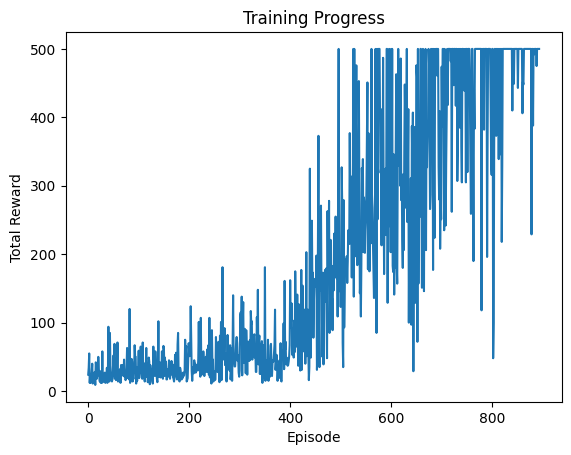

In [ ]:
# Initialize the agent
agent = REINFORCE(env_name='CartPole-v1')

# Train the agent
rewards = agent.train(max_episodes=2000)

# Plot training rewards
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.title("Training Progress")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

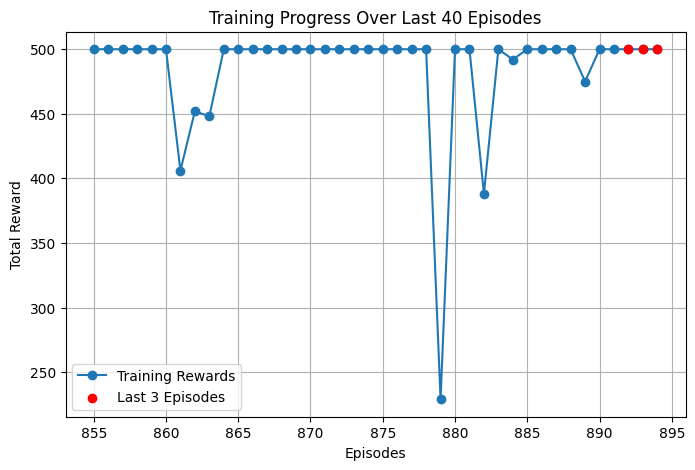

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load training rewards from saved file
training_rewards = np.load("training_rewards.npy")

# Select the last 40 episodes for visualization
num_episodes = 40
if len(training_rewards) < num_episodes:
    num_episodes = len(training_rewards)  # Adjust if fewer than 40 episodes

rewards_subset = training_rewards[-num_episodes:]  # Extract last 40 episodes
episodes = np.arange(len(training_rewards) - num_episodes + 1, len(training_rewards) + 1)

# Plot the training progress
plt.figure(figsize=(8, 5))
plt.plot(episodes, rewards_subset, label="Training Rewards", marker="o", linestyle="-")

# Highlight the last three recorded results
plt.scatter(episodes[-3:], rewards_subset[-3:], color="red", label="Last 3 Episodes", zorder=3)

# Labels and title
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Training Progress Over Last 40 Episodes")
plt.legend()
plt.grid(True)

# Show the graph
plt.show()

#Arcitecture Two

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import gym

class REINFORCE:
    def __init__(self, env_name='CartPole-v1', learning_rate=0.001, gamma=0.99):
        self.env = gym.make(env_name, new_step_api=True)
        #observation_space.shape is (4,), which is a tuple.
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.gamma = gamma

        # Create policy network
        self.model = Sequential([
            Input(shape=(self.state_dim,)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(self.action_dim, activation='softmax')
        ])

        self.model.compile(optimizer=Adam(learning_rate=learning_rate))

    def compute_returns(self, rewards):
        """
        Compute discounted returns from rewards.
        """
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)
        returns = np.array(returns, dtype='float32')
        # Normalize returns
        #Returns can have widely varying scales depending on the rewards and discount factor (γ) used.
        #Large return values can cause large gradient updates, leading to instability during training.
        #Normalization ensures that the scale of the updates is more consistent.
        returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
        return returns


    def reinforce_loss(self, states, actions, returns):
        """
        Custom loss function for REINFORCE, with model inference included.

        Args:
            states: The input states for the policy model.
            actions: The actions taken (as integers).
            returns: The discounted returns for each timestep.
        """
        # Get probabilities from the model
        probs = self.model(states)  # Run the model to get action probabilities

        # One-hot encode actions
        action_masks = tf.one_hot(actions, self.action_dim)

        # Select the probabilities of the taken actions
        selected_action_probs = tf.reduce_sum(probs * action_masks, axis=1)

        # Compute log probabilities
        log_probs = tf.math.log(selected_action_probs + 1e-8)

        # Compute the loss as the negative weighted log-probabilities
        loss = -tf.reduce_mean(log_probs * returns)

        return loss

    def train_episode(self):
        """
        Run a single episode and train the model using its data.
        """
        state = self.env.reset()
        if isinstance(state, tuple):  # Handle different gym versions
            state = state[0]

        states = []
        actions = []
        rewards = []

        done = False
        while not done:
            # Get action from the agent
            state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)  # Convert state to a TensorFlow tensor
            state_tensor = tf.expand_dims(state_tensor, axis=0)           # Add a batch dimension
            action_probs = self.model(state_tensor).numpy()
            #The model returns probabilities for a batch of states, even if there’s only a single state in the batch.
            #The [0] is used to extract the probabilities for the first (and only) state in the batch.
            action = np.random.choice(self.action_dim, p=action_probs[0])

            # Perform action in the environment
            step_result = self.env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, done, truncated, _ = step_result
                done = done or truncated

            # Store the transition
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state

        # Convert collected data into arrays
        states = np.array(states, dtype='float32')
        actions = np.array(actions, dtype='int32')
        returns = self.compute_returns(rewards)

        # Train the model using the collected episode data
        with tf.GradientTape() as tape:
            loss = self.reinforce_loss(states, actions, returns)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        return sum(rewards)  # Return total reward for the episode

    def train(self, max_episodes=1000, target_average_reward=480, window=80):
        """
        Train the agent over multiple episodes.

        Args:
            max_episodes: Maximum number of episodes to train.
            target_average_reward: Stop training if the average reward of the last
                                   'window' episodes exceeds this value.
            window: Number of episodes to consider for average reward.
        """
        episode_rewards = []

        for episode in range(max_episodes):
            total_reward = self.train_episode()
            episode_rewards.append(total_reward)

            # Print progress every 10 episodes
            if (episode + 1) % 10 == 0:
                avg_reward = np.mean(episode_rewards[-10:])
                print(f"Episode {episode + 1}, Average Reward (last 10): {avg_reward:.2f}")

            # Check for early stopping
            if len(episode_rewards) >= window and np.mean(episode_rewards[-window:]) >= target_average_reward:
                print(f"Environment solved in {episode + 1} episodes! "
                      f"Average reward over the last {window} episodes: "
                      f"{np.mean(episode_rewards[-window:]):.2f}")
                break
                # Compute and print the final average reward over the last 40 episodes
        last_40_avg = np.mean(episode_rewards[-40:]) if len(episode_rewards) >= 40 else np.mean(episode_rewards)
        print(f"Final Average Reward over the Last 40 Episodes: {last_40_avg:.2f}")

        # Save rewards to a file
        np.save("training_rewards.npy", np.array(episode_rewards))



        return episode_rewards

    def inference(self, num_episodes=2, render=True):
        #"""Run inference using the trained policy"""
        for episode in range(num_episodes):
            state = self.env.reset()
            if isinstance(state, tuple):
                state = state[0]

            done = False
            total_reward = 0
            steps = 0

            while not done:
                if render:
                    self.env.render()  # Render the environment

                # Get action using the trained policy (using argmax instead of sampling)
                state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
                action_probs = self.model(state_tensor).numpy()
                action = np.argmax(action_probs[0])  # Take the most probable action

                # Take action in environment
                step_result = self.env.step(action)
                if len(step_result) == 4:
                    state, reward, done, _ = step_result
                else:
                    state, reward, done, truncated, _ = step_result
                    done = done or truncated

                total_reward += reward
                steps += 1
            print(total_reward)


Episode 10, Average Reward (last 10): 21.90
Episode 20, Average Reward (last 10): 20.70
Episode 30, Average Reward (last 10): 21.50
Episode 40, Average Reward (last 10): 30.20
Episode 50, Average Reward (last 10): 38.90
Episode 60, Average Reward (last 10): 35.80
Episode 70, Average Reward (last 10): 40.90
Episode 80, Average Reward (last 10): 41.10
Episode 90, Average Reward (last 10): 28.60
Episode 100, Average Reward (last 10): 24.60
Episode 110, Average Reward (last 10): 43.80
Episode 120, Average Reward (last 10): 51.60
Episode 130, Average Reward (last 10): 42.30
Episode 140, Average Reward (last 10): 60.40
Episode 150, Average Reward (last 10): 44.70
Episode 160, Average Reward (last 10): 53.50
Episode 170, Average Reward (last 10): 87.60
Episode 180, Average Reward (last 10): 84.10
Episode 190, Average Reward (last 10): 74.40
Episode 200, Average Reward (last 10): 112.40
Episode 210, Average Reward (last 10): 121.80
Episode 220, Average Reward (last 10): 119.90
Episode 230, Ave

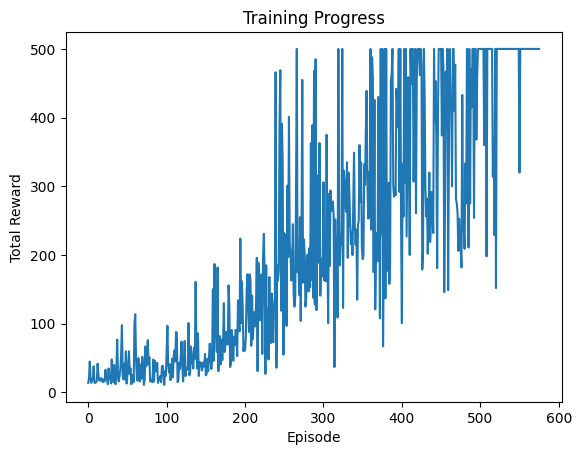

In [ ]:
# Initialize the agent
agent = REINFORCE(env_name='CartPole-v1')

# Train the agent
rewards = agent.train(max_episodes=2000)

# Plot training rewards
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.title("Training Progress")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

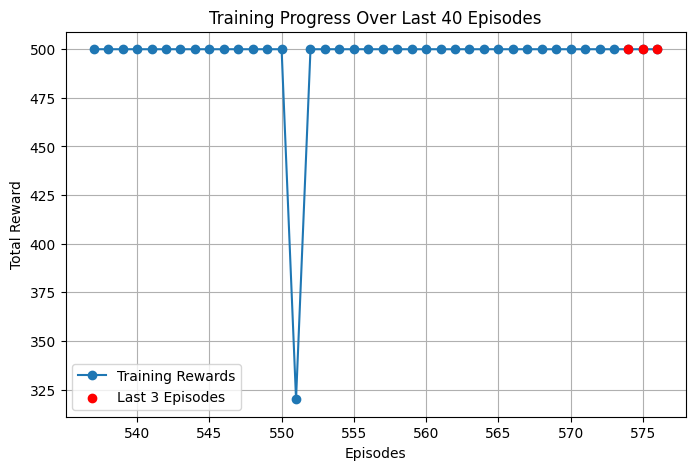

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load training rewards from saved file
training_rewards = np.load("training_rewards.npy")

# Select the last 40 episodes for visualization
num_episodes = 40
if len(training_rewards) < num_episodes:
    num_episodes = len(training_rewards)  # Adjust if fewer than 40 episodes

rewards_subset = training_rewards[-num_episodes:]  # Extract last 40 episodes
episodes = np.arange(len(training_rewards) - num_episodes + 1, len(training_rewards) + 1)

# Plot the training progress
plt.figure(figsize=(8, 5))
plt.plot(episodes, rewards_subset, label="Training Rewards", marker="o", linestyle="-")

# Highlight the last three recorded results
plt.scatter(episodes[-3:], rewards_subset[-3:], color="red", label="Last 3 Episodes", zorder=3)

# Labels and title
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Training Progress Over Last 40 Episodes")
plt.legend()
plt.grid(True)

# Show the graph
plt.show()

#Architecture Three

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import gym

class REINFORCE:
    def __init__(self, env_name='CartPole-v1', learning_rate=0.001, gamma=0.99):
        self.env = gym.make(env_name, new_step_api=True)
        #observation_space.shape is (4,), which is a tuple.
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.gamma = gamma

        # Create policy network
        self.model = Sequential([
            Input(shape=(self.state_dim,)),
            Dense(256, activation='relu'),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(self.action_dim, activation='softmax')
        ])

        self.model.compile(optimizer=Adam(learning_rate=learning_rate))

    def compute_returns(self, rewards):
        """
        Compute discounted returns from rewards.
        """
        returns = []
        G = 0
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)
        returns = np.array(returns, dtype='float32')
        # Normalize returns
        #Returns can have widely varying scales depending on the rewards and discount factor (γ) used.
        #Large return values can cause large gradient updates, leading to instability during training.
        #Normalization ensures that the scale of the updates is more consistent.
        returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
        return returns


    def reinforce_loss(self, states, actions, returns):
        """
        Custom loss function for REINFORCE, with model inference included.

        Args:
            states: The input states for the policy model.
            actions: The actions taken (as integers).
            returns: The discounted returns for each timestep.
        """
        # Get probabilities from the model
        probs = self.model(states)  # Run the model to get action probabilities

        # One-hot encode actions
        action_masks = tf.one_hot(actions, self.action_dim)

        # Select the probabilities of the taken actions
        selected_action_probs = tf.reduce_sum(probs * action_masks, axis=1)

        # Compute log probabilities
        log_probs = tf.math.log(selected_action_probs + 1e-8)

        # Compute the loss as the negative weighted log-probabilities
        loss = -tf.reduce_mean(log_probs * returns)

        return loss

    def train_episode(self):
        """
        Run a single episode and train the model using its data.
        """
        state = self.env.reset()
        if isinstance(state, tuple):  # Handle different gym versions
            state = state[0]

        states = []
        actions = []
        rewards = []

        done = False
        while not done:
            # Get action from the agent
            state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)  # Convert state to a TensorFlow tensor
            state_tensor = tf.expand_dims(state_tensor, axis=0)           # Add a batch dimension
            action_probs = self.model(state_tensor).numpy()
            #The model returns probabilities for a batch of states, even if there’s only a single state in the batch.
            #The [0] is used to extract the probabilities for the first (and only) state in the batch.
            action = np.random.choice(self.action_dim, p=action_probs[0])

            # Perform action in the environment
            step_result = self.env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, done, truncated, _ = step_result
                done = done or truncated

            # Store the transition
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state

        # Convert collected data into arrays
        states = np.array(states, dtype='float32')
        actions = np.array(actions, dtype='int32')
        returns = self.compute_returns(rewards)

        # Train the model using the collected episode data
        with tf.GradientTape() as tape:
            loss = self.reinforce_loss(states, actions, returns)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        return sum(rewards)  # Return total reward for the episode

    def train(self, max_episodes=1000, target_average_reward=480, window=80):
      """
      Train the agent over multiple episodes.

      Args:
          max_episodes: Maximum number of episodes to train.
          target_average_reward: Stop training if the average reward of the last 'window' episodes exceeds this value.
          window: Number of episodes to consider for early stopping.
      """
      episode_rewards = []

      for episode in range(max_episodes):
          total_reward = self.train_episode()
          episode_rewards.append(total_reward)

          # Print progress every 10 episodes
          if (episode + 1) % 10 == 0:
              avg_reward = np.mean(episode_rewards[-10:])
              print(f"Episode {episode + 1}, Average Reward (last 10): {avg_reward:.2f}")

          # Check for early stopping
          if len(episode_rewards) >= window and np.mean(episode_rewards[-window:]) >= target_average_reward:
              print(f"Environment solved in {episode + 1} episodes! "
                    f"Average reward over the last {window} episodes: {np.mean(episode_rewards[-window:]):.2f}")
              break

      # Compute and print the final average reward over the last 40 episodes
      last_40_avg = np.mean(episode_rewards[-40:]) if len(episode_rewards) >= 40 else np.mean(episode_rewards)
      print(f"Final Average Reward over the Last 40 Episodes: {last_40_avg:.2f}")

      # Save rewards to a file
      np.save("training_rewards.npy", np.array(episode_rewards))

      return episode_rewards


    def inference(self, num_episodes=2, render=True):
        #"""Run inference using the trained policy"""
        for episode in range(num_episodes):
            state = self.env.reset()
            if isinstance(state, tuple):
                state = state[0]

            done = False
            total_reward = 0
            steps = 0

            while not done:
                if render:
                    self.env.render()  # Render the environment

                # Get action using the trained policy (using argmax instead of sampling)
                state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
                action_probs = self.model(state_tensor).numpy()
                action = np.argmax(action_probs[0])  # Take the most probable action

                # Take action in environment
                step_result = self.env.step(action)
                if len(step_result) == 4:
                    state, reward, done, _ = step_result
                else:
                    state, reward, done, truncated, _ = step_result
                    done = done or truncated

                total_reward += reward
                steps += 1
            print(total_reward)


  and should_run_async(code)

  if not isinstance(terminated, (bool, np.bool8)):



Episode 10, Average Reward (last 10): 27.70
Episode 20, Average Reward (last 10): 20.50
Episode 30, Average Reward (last 10): 28.10
Episode 40, Average Reward (last 10): 39.10
Episode 50, Average Reward (last 10): 36.70
Episode 60, Average Reward (last 10): 66.30
Episode 70, Average Reward (last 10): 44.90
Episode 80, Average Reward (last 10): 27.00
Episode 90, Average Reward (last 10): 50.00
Episode 100, Average Reward (last 10): 117.30
Episode 110, Average Reward (last 10): 93.60
Episode 120, Average Reward (last 10): 88.60
Episode 130, Average Reward (last 10): 95.70
Episode 140, Average Reward (last 10): 146.60
Episode 150, Average Reward (last 10): 115.00
Episode 160, Average Reward (last 10): 140.40
Episode 170, Average Reward (last 10): 138.00
Episode 180, Average Reward (last 10): 151.80
Episode 190, Average Reward (last 10): 231.70
Episode 200, Average Reward (last 10): 125.60
Episode 210, Average Reward (last 10): 127.70
Episode 220, Average Reward (last 10): 80.40
Episode 23

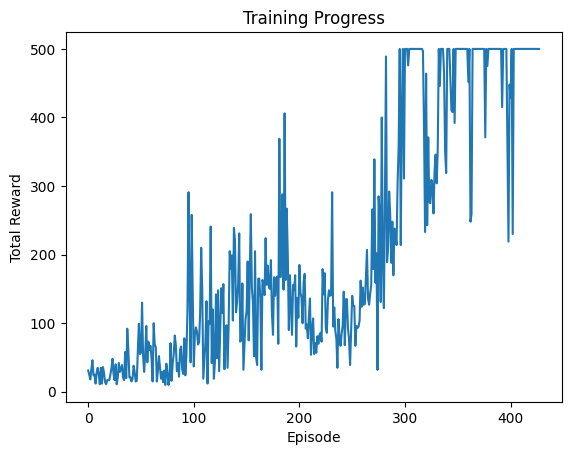

In [8]:
# Initialize the agent
agent = REINFORCE(env_name='CartPole-v1')

# Train the agent
rewards = agent.train(max_episodes=2000)

# Plot training rewards
import matplotlib.pyplot as plt

plt.plot(rewards)
plt.title("Training Progress")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

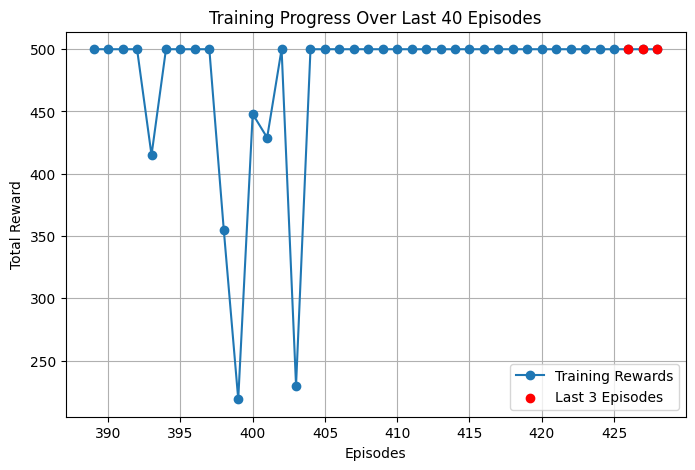

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load training rewards from saved file
training_rewards = np.load("training_rewards.npy")

# Select the last 40 episodes for visualization
num_episodes = 40
if len(training_rewards) < num_episodes:
    num_episodes = len(training_rewards)  # Adjust if fewer than 40 episodes

rewards_subset = training_rewards[-num_episodes:]  # Extract last 40 episodes
episodes = np.arange(len(training_rewards) - num_episodes + 1, len(training_rewards) + 1)

# Plot the training progress
plt.figure(figsize=(8, 5))
plt.plot(episodes, rewards_subset, label="Training Rewards", marker="o", linestyle="-")

# Highlight the last three recorded results
plt.scatter(episodes[-3:], rewards_subset[-3:], color="red", label="Last 3 Episodes", zorder=3)

# Labels and title
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Training Progress Over Last 40 Episodes")
plt.legend()
plt.grid(True)

# Show the graph
plt.show()


#Continue

In [ ]:
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.models import load_model


In [ ]:
# 2. Save the trained model
agent.model.save('reinforce_cartpole.h5')

In [ ]:
# 3. To load and run inference later:
# Create a new agent
inference_agent = REINFORCE(env_name='CartPole-v1')
# Load the trained weights
inference_agent.model = load_model('reinforce_cartpole.h5')# Run inference
inference_agent.inference(num_episodes=2, render=True)

If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



500.0
500.0


In [ ]:
import gym
import tensorflow as tf
import imageio
from IPython.display import Video
import numpy as np

# Initialize the inference agent
inference_agent = REINFORCE(env_name='CartPole-v1')

# Load the trained weights
inference_agent.model = load_model('reinforce_cartpole.h5')# Run inference

# Set up the environment for rendering
env = gym.make('CartPole-v1', render_mode='rgb_array')
state = env.reset()

if isinstance(state, tuple):  # Handle different gym versions
    state = state[0]

frames = []
done = False
iteration = 0

# Run the episode and render each frame as an image
while not done:
    iteration += 1

    # Get action using the trained policy (argmax instead of sampling)
    state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)
    action_probs = inference_agent.model(state_tensor).numpy()
    action = tf.argmax(action_probs[0]).numpy()  # Use the most probable action

    # Step through the environment
    step_result = env.step(action)
    if len(step_result) == 4:
        state, reward, done, _ = step_result
    else:
        state, reward, done, truncated, _ = step_result
        done = done or truncated

    # Render the frame
    frame = env.render()  # Returns a graphical frame

    # Ensure the frame is a numpy array
    if isinstance(frame, list):  # Convert list to numpy array
        frame = np.array(frame)

    # Handle batched frames (select the first frame if batched)
    if frame.ndim == 4:  # Batched format (e.g., (1, 400, 600, 3))
        frame = frame[0]
    elif frame.ndim == 5:  # Unexpected batch format
        raise ValueError(f"Unexpected batch format in frame: {frame.shape}")

    frames.append(frame)

# Close the environment
env.close()



  deprecation(

  deprecation(



In [ ]:
# Save the video file
video_filename = 'cartpole_inference.mp4'
with imageio.get_writer(video_filename, fps=12) as video:
    for frame in frames:
        video.append_data(frame)

# Display the saved video in the notebook
Video(video_filename, embed=True)
